# Extracción del Conjunto de Datos 

En el presete notebook se detallan los pasos para la construcción del conjunto de datos que será usado para el entrenamiento de los modelos de máquinas de aprendizaje. Al finalizar el presente notebook se pretende tener un dataset con las siguientes característcias de las imágenes satelitales:

| blue | green | red | nir | swir1 | swir2 | wofs | bosque | wofs_bosque | cloud  | ninguno |
|------|-------|-----|-----|-------|-------|------|--------|-------------|--------|---------|
|      |       |     |     |       |       |      |        |             |        |         |

Donde **blue**, **green**, **red**, **nir**, **swir1**, **swir2** son las respectivas respuestas espectrales de una imagen Landsat 8 para cada pixel de la imágen. **wofs** es una clasificación de la covertura terrestre en agua (1) no agua (0). Y **bosque**, es una clasificación de la cobertura en bosque (1) no bosque (0). **wofs_bosque**, puede ocurrir que el algoritmo de bósque clasifique un pixel como bósque (1) y el algoritmo de água clasifique el mísmo pixel como agua. Esto puede deberse a que el pixel (30 metros x 30 metros) esté parcialmente cubierto por agua y parcialmente por bosque. **cloud**, representan aquéllos pixeles con álta probabilidad de ser nubes (*high confidence cloud* deacuerdo al pixel_qa).  **ninguno**, es una clasificación dada a aquellos pixeles que no se encuentran en las categorias anteriores, estos pixeles pueden representar areas urbanizadas o desiertas.

### Procesamiento de Imagenes Satelitales Landsat 8 OLI LASRC

Las escenas **Landsat 8 OLI LASRC** tomadas en este trabajo, son imágenes pertenecientes a la Colección 1 - Nivel 2 (On demand) del catálogo de imagenes USGS Earth Explorer. Las imagenes del Nivel 2 presentan correcciones atmosfericas de reflectancia de superficie (Surface Reflectance SR). Estas correcciones mitigan el efecto de los gases o aerosoles que se encuentran en la atmosfera y pueden afectar la reflectancia de la tierra sensada por el satelite (sensor). Las correcciones atmosféricas son llevadas a cabo por el algoritmo LASRC (Landsat Surface Reflectance Code)

Durante la generación de las scenas corregidas en superficie de reflectancia, el algoritmo LASRC evalua la calidad de cada pixel y esta información la información de esta evaluación la registra en 3 bandas (**sr_aeroso**, **pixel_qa**, **radsat_qa**) que se generan de forma adicional al finalizar la corección de reflectancia.

El rango de valores que se pueden encontrar para cada pixel en las respectivas bandas son:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768 
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768


## Referencias
1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from rasterio.plot import show
import pandas as pd
import numpy as np
import xarray as xr

# Wofs imports
import gc
import collections
# Genrales
import rasterio
import os
import glob
import random

## NDVI Normalized Vegetation Index 

El Índice de Vegetación de Diferencia Normalizada (NDVI) cuantifica la vegetación midiendo la diferencia entre el infrarrojo cercano **nir** (que la vegetación refleja fuertemente) y la luz roja **red** (que la vegetación absorbe). NDVI siempre varía de -1 a +1. No hay un límite distinto para cada tipo de cobertura del suelo.

Valores del NDVI

* **Valores Negativos:** Es muy probable que sea agua.
* **Valores Cercanos a 1:** Existe una alta posibilidad de que sean hojas verdes densas.
* **Valores Cercanos a 0:** No hay hojas verdes e incluso podría ser un área urbanizada.

### Referencia

1. [What is NDVI (Normalized Difference Vegetation Index)?](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)

In [2]:
def ndvi(red,nir):
    """Indice de Vegetación Normalizado.
    
    Args:
        red (xarray.DataArray): Banda red .
        nir (xarray.DataArray): Banda nir.
        
    Returns:
        xarray.DataArray: Matr
    """
    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = red.values
    period_nir = nir.values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array

## Bosque No Bosque

"La clasificación de Bosque/NoBosque utiliza como base del análisis de NDVI, sobre el cual el algoritmo recorre la imagen por una ventana definida por el usuario (p.e. 3x3, 1x1 pixeles), validando mediante un umbral dado por el usuario, cuales son los pixeles que pueden ser considerados como bosque y no bosque."

### Referencias

1. [bosque-no-bosque-wf_1.0.py ](https://github.com/OpenDatacubeIDEAM/cdcol-workflows/blob/master/algorithms/bosque-no-bosque-wf/bosque-no-bosque-wf_1.0.py)

In [3]:
def forest_no_forest(ndvi, ndvi_threshold=0.7, vegetation_rate=0.3, slice_size=2):
    """Clasificación Boque no Bosque.
    
    Esta clasificación necesita como insumo el NDVI.
    
    Args:
        ndvi (xarray.DataArray): NDVI.
        ndvi_threshold (float): Umbral del bosque.
        vegetation_rate (float): Tasa de vegetación (complementa ndvi_threshold).
        slice_size (int): Tamaño de ventana a considerar para análisis de bosque.
        
    Returns:
        xarray.DataArray: Clasificación binaria bosque (1) no bosuqe (0).    
    """
    
    ndvi_data = ndvi.copy(deep=True)
    # Dado que bosque no bosque es una clasificación
    # binaria, los valores son número enteros 
    # por lo tanto nodata no puede ser igual a NaN
    nodata = -9999

    # ndvi_data = ndvi_data.squeeze(['dim_0'])
    nvdi_array = ndvi_data.values

    # Umbral de Bosque
    # ndvi_threshold = 0.7

    # Tasa de Vegetación 
    # vegetation_rate = 0.3

    # Tamaño de Ventana
    # slice_size = 2

    height = nvdi_array.shape[0]
    width = nvdi_array.shape[1]
    bosque_nobosque=np.full(nvdi_array.shape, -1)
    for y1 in range(0, height, slice_size):
        for x1 in range(0, width, slice_size):
            x2 = x1 + slice_size
            y2 = y1 + slice_size
            if(x2 > width):
                x2 = width
            if(y2 > height):
                y2 = height
            submatrix = nvdi_array[y1:y2,x1:x2]
            ok_pixels = np.count_nonzero(~np.isnan(submatrix))
            if ok_pixels==0:
                bosque_nobosque[y1:y2,x1:x2] = nodata
            elif np.nansum(submatrix>ndvi_threshold)/ok_pixels >= vegetation_rate :
                bosque_nobosque[y1:y2,x1:x2] = 1
            else:
                bosque_nobosque[y1:y2,x1:x2] = 0

    # Los valores que son iguales a nodata=-9999 los 
    # los convertimos a 0 (no bosque)
    mask_nan=np.isin(bosque_nobosque,[nodata])
    bosque_nobosque[mask_nan] = 0

    data_array_bosque = xr.DataArray(data=bosque_nobosque)
    
    return data_array_bosque

## Water Observation from Space

"El algoritmo de clasificación WOFS (Water Observations from Space), permite una clasificación de Agua/noAgua  usando un árbol de regresión entrenado para la clasificación de la cobertura de agua a lo largo de un periodo de tiempo. Las salidas del algoritmo WOFS incluyen observaciones de clasificación de agua a nivel de píxeles estáticos para cada periodo evaluado, y de series de tiempo para cualquier píxel dentro de una misma zona."

### References

1. [Cubo de Datos de Imágenes de Satelite de Colombia - IDEAM](http://cdcol.ideam.gov.co/)
2. [Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia](https://www.sciencedirect.com/science/article/pii/S0034425715301929)

In [4]:
def wofs_classify(dataset_in, clean_mask=None, no_data=-9999, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset. If no clean mask is given, the 'cf_mask'
      variable must be included in the input dataset, as it will be used to create a 
      clean mask
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7 
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from 
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
        If user does not provide a clean_mask, dataset_in must also include the cf_mask
        variable
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, one will be created using cfmask
      no_data (int/float) - no data pixel value; default: -9999
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    """
    
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)
        
    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """
        
        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)
        
        #classified = np.ones(shape, dtype='uint8')
        
        classified = np.full(shape, no_data)
      
        # Start with the tree's left branch, finishing nodes as needed
        
        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0 #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1 #Node 6
        classified[_tmp2 & ~r4] = 0 #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1 #Node 10
        classified[_tmp2 & ~r6] = 0 #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1 #Node 14
        classified[_tmp2 & ~r8] = 0 #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1 #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1 #Node 19
        classified[_tmp & ~r10] = 0 #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()
        
        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0 #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0 #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1 #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1 #Node 31
        classified[_tmp2 & ~r16] = 0 #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1 #Node 33
        classified[_tmp2] = 0 #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0 #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0 #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0 #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0 #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1 #Node 44
        classified[_tmp & ~r22] = 0 #Node 45

        # Completed regression tree
        
        return classified
    
    # Extract dataset bands needed for calculations
    blue = dataset_in["blue"]
    green = dataset_in["green"]
    red = dataset_in["red"]
    nir = dataset_in["nir"]
    swir1 = dataset_in["swir1"]
    swir2 = dataset_in["swir2"]
    
    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype # This assumes all dataset bands will have
                              # the same dtype (should be a reasonable
                              # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')
    
    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, 
                                 nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data)
    classified_clean[clean_mask] = classified[clean_mask] # Contains data for clear pixels
    dataset_out = xr.DataArray(classified_clean)
    return dataset_out

## Funciones Auxiliares

In [5]:
def find_band_path(band_name,base_path):
    lookup = path + '/*.tif'
    bands_paths = glob.glob(lookup)
    
    condition = lambda file_name: band_name in file_name
    result = list(filter(condition,bands_paths))

    # result debería tener un único valor desde que 
    # un único path contiene el string que representa
    # la variable band_name
    assert len(result) == 1, 'Nombre de la banda incompleto'
    return result.pop(0)

def load_data_array(tif_path):
    array = xr.open_rasterio(tif_path)
    # Remueve la primer dimensión
    # para obtener un arreglo de dos dimensiones
    return array.squeeze(axis=0)


def load_data(path,bands_mapping):
    bands_dict = {}
    for band_name, alias in bands_mapping:
        bands_dict[alias] = load_data_array(find_band_path(band_name,path))
        
    return bands_dict

## Carga de Archivos .tif

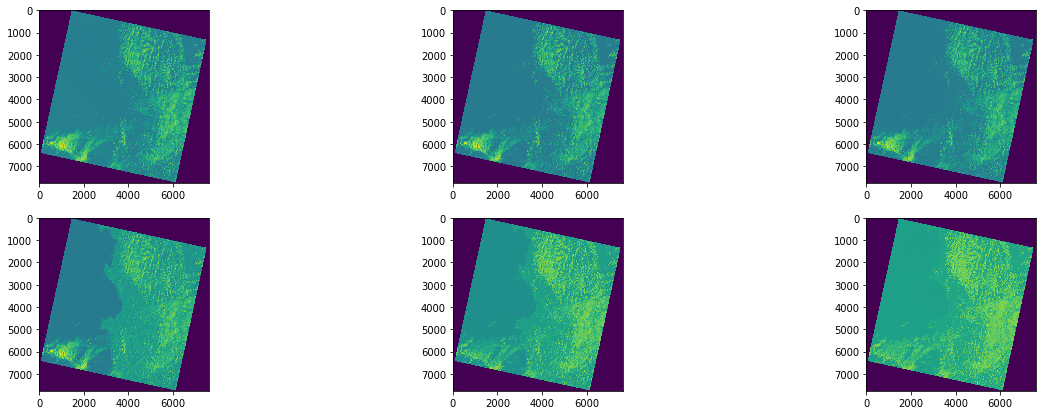

In [6]:
# path = '../data/choco/LC080100562018011001T1-SC20191101092114'
# path = '../data/choco/LC080100562018022701T1-SC20191101092059'
path = '../../data/choco/'

band_names = [
    ('band2','blue'),
    ('band3','green'),
    ('band4','red'),
    ('band5','nir'),
    ('band6','swir1'),
    ('band7','swir2'),
    ('pixel_qa','pixel_qa'),
]

current_img_dict = load_data(path,band_names)

fig, axs = plt.subplots(2, 3,figsize=(21,7))

show(current_img_dict['blue'],ax=axs[0,0])
show(current_img_dict['red'],ax=axs[0,1])
show(current_img_dict['green'],ax=axs[0,2])
show(current_img_dict['nir'],ax=axs[1,0])
show(current_img_dict['swir1'],ax=axs[1,1])
show(current_img_dict['swir2'],ax=axs[1,2])

In [7]:
current_img_dict['blue'].values[0][0]

-9999

## Eliminar Valores Invalidos

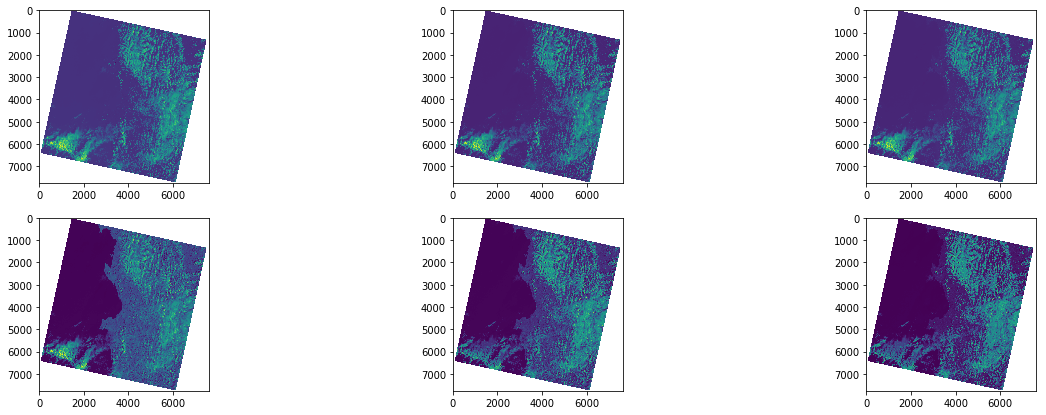

In [8]:
# Los valores invalidos son -9999
nodata = -9999
bands = ['blue','green','red','nir','swir1','swir2']

has_information = current_img_dict['blue'] != nodata
for band in bands:
    current_img_dict[band].values = np.where(has_information,current_img_dict[band],np.nan)

fig, axs = plt.subplots(2, 3,figsize=(21,7))

show(current_img_dict['blue'],ax=axs[0,0])
show(current_img_dict['red'],ax=axs[0,1])
show(current_img_dict['green'],ax=axs[0,2])
show(current_img_dict['nir'],ax=axs[1,0])
show(current_img_dict['swir1'],ax=axs[1,1])
show(current_img_dict['swir2'],ax=axs[1,2])

In [9]:
has_information

<xarray.DataArray (y: 7761, x: 7611)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band     int64 1
  * y        (y) float64 7.56e+05 7.56e+05 7.559e+05 ... 5.232e+05 5.232e+05
  * x        (x) float64 1.383e+05 1.383e+05 1.384e+05 ... 3.666e+05 3.666e+05

## Clasificación de Agua

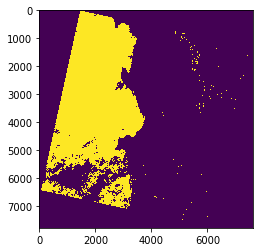

In [10]:
import warnings
warnings.filterwarnings('ignore')

wofs_results = wofs_classify(current_img_dict)
current_img_dict["wofs"] = wofs_results
show(wofs_results)

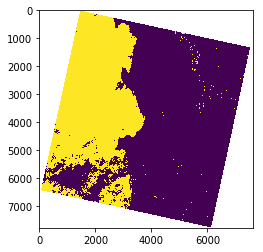

In [11]:
current_img_dict["wofs"].values = np.where(has_information,current_img_dict["wofs"],np.nan)
show(current_img_dict["wofs"])

## Indice de Vegetación

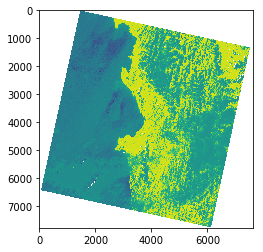

In [12]:
import warnings
warnings.filterwarnings('ignore')

ndvi_results = ndvi(current_img_dict['red'],current_img_dict['nir'])
current_img_dict["ndvi"] = ndvi_results
show(ndvi_results)

## Clasificación de Bósque

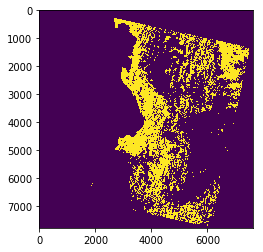

In [13]:
forest_no_forest_results = forest_no_forest(ndvi_results)
current_img_dict["bosque"] = forest_no_forest_results
show(forest_no_forest_results)

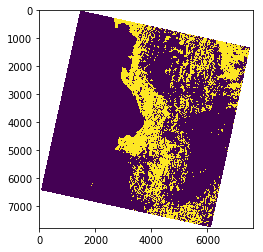

In [14]:
current_img_dict["bosque"].values = np.where(has_information,current_img_dict["bosque"] ,np.nan)
show(current_img_dict["bosque"])

## Construcción del DataFrame

In [15]:
max_data = 1000000

data_points = np.argwhere(~np.isnan(current_img_dict["ndvi"].values))
data_points = random.sample(list(data_points), max_data)

def is_cloud(value):
    
    cloud_shadow = [328, 392, 840, 904, 1350]
    cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
    low_confidence_cloud = [322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880]
    medium_confidence_cloud = [386, 388, 392, 400, 416, 432, 898, 900, 904, 928, 944]
    high_confidence_cloud = [480, 992]

    cloud_values =  high_confidence_cloud

    return 1 if value in cloud_values else 0

data = []
for i,j in data_points:
    blue = current_img_dict['blue'].values[i,j]
    green = current_img_dict['green'].values[i,j]
    red = current_img_dict['red'].values[i,j]
    nir = current_img_dict['nir'].values[i,j]
    swir1 = current_img_dict['swir1'].values[i,j]
    swir2 = current_img_dict['swir2'].values[i,j]
    wofs = int(current_img_dict['wofs'].values[i,j])
    bosque = int(current_img_dict['bosque'].values[i,j])
    cloud = is_cloud(current_img_dict['pixel_qa'].values[i,j])
   
    if cloud == 1:
        wofs = 0
        bosque = 0
        ninguno = 0
        wofs_bosque = 0
    elif wofs==1 and bosque==1:
        wofs = 0
        bosque = 0
        ninguno = 0
        wofs_bosque = 1
    elif wofs==0 and bosque==0:
        ninguno = 1
        wofs_bosque = 0
    else:
        ninguno = 0
        wofs_bosque = 0

    data.append([blue,green,red,nir,swir1,swir2,wofs,bosque,wofs_bosque,ninguno,cloud])
    
df = pd.DataFrame(data,columns=[
    'blue', 'green', 'red','nir','swir1','swir2','wofs','bosque','wofs_bosque','ninguno','cloud'
])
df.head()

,blue,green,red,nir,swir1,swir2,wofs,bosque,wofs_bosque,ninguno,cloud
0,8452.0,8750.0,8900.0,9146.0,6759.0,4585.0,0,0,0,0,1
1,299.0,203.0,100.0,73.0,79.0,60.0,1,0,0,0,0
2,5167.0,4956.0,4945.0,5647.0,3920.0,2588.0,0,0,0,0,1
3,245.0,177.0,93.0,75.0,100.0,80.0,1,0,0,0,0
4,259.0,179.0,92.0,64.0,89.0,72.0,1,0,0,0,0


In [16]:
df.to_csv('satellite_dataset-con-nubes.csv',sep=',',index=False)

In [17]:
df['wofs'].value_counts()

0    659248
1    340752
Name: wofs, dtype: int64

In [18]:
df['bosque'].value_counts()

0    782572
1    217428
Name: bosque, dtype: int64

In [19]:
df['wofs_bosque'].value_counts()

0    999830
1       170
Name: wofs_bosque, dtype: int64

In [20]:
df['ninguno'].value_counts()

0    954635
1     45365
Name: ninguno, dtype: int64

In [21]:
df['cloud'].value_counts()

0    603715
1    396285
Name: cloud, dtype: int64